In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from scipy.stats import skew
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [4]:
train.head()
holdout.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train.info(verbose=False)
holdout.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 924.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 80 entries, Id to SaleCondition
dtypes: float64(11), int64(26), object(43)
memory usage: 912.0+ KB


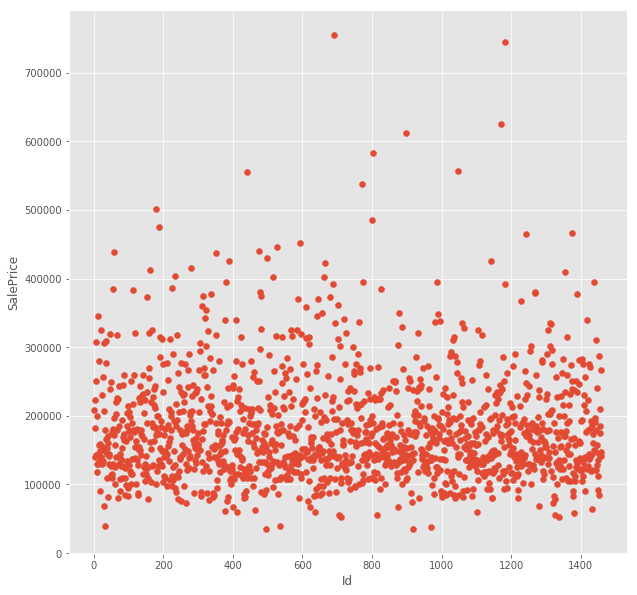

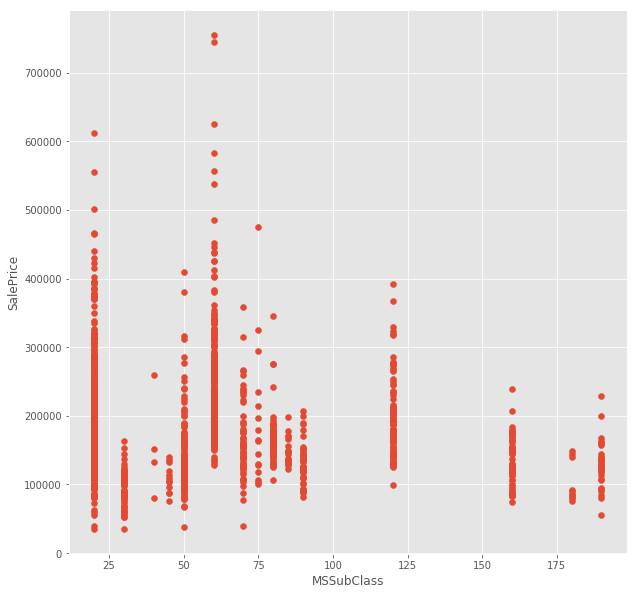

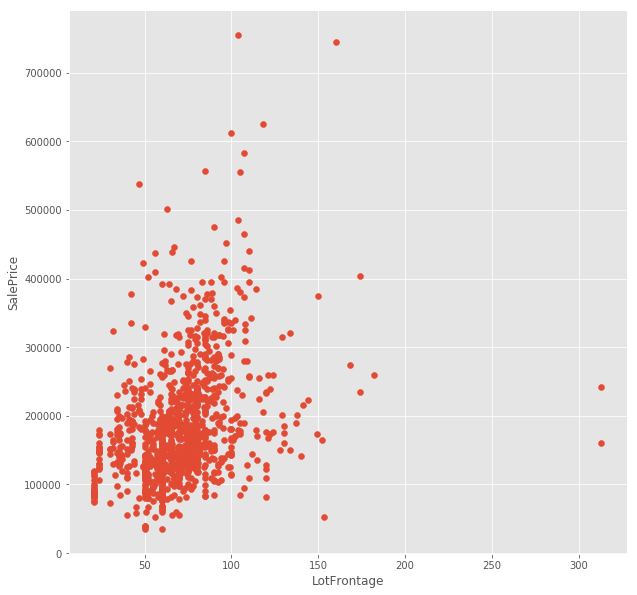

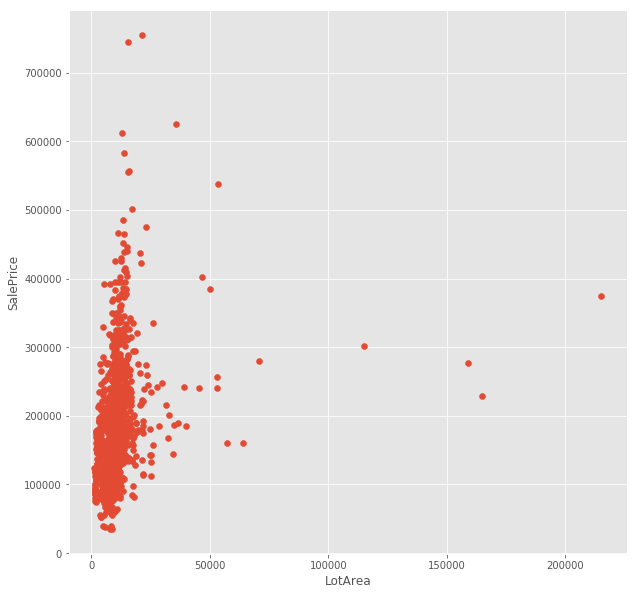

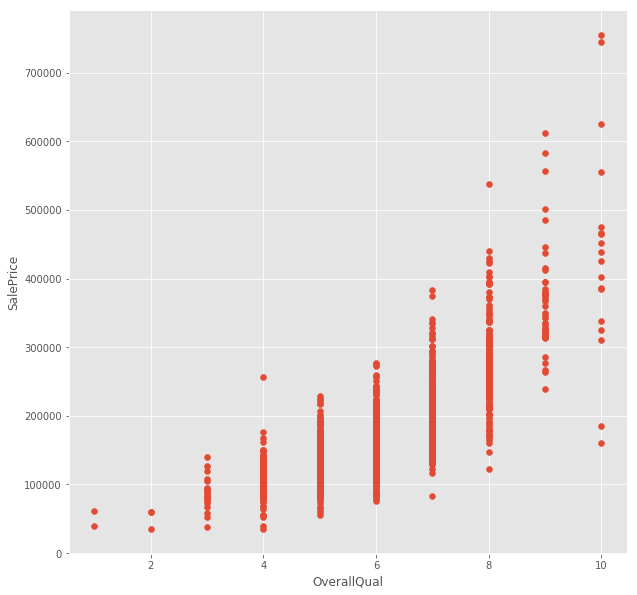

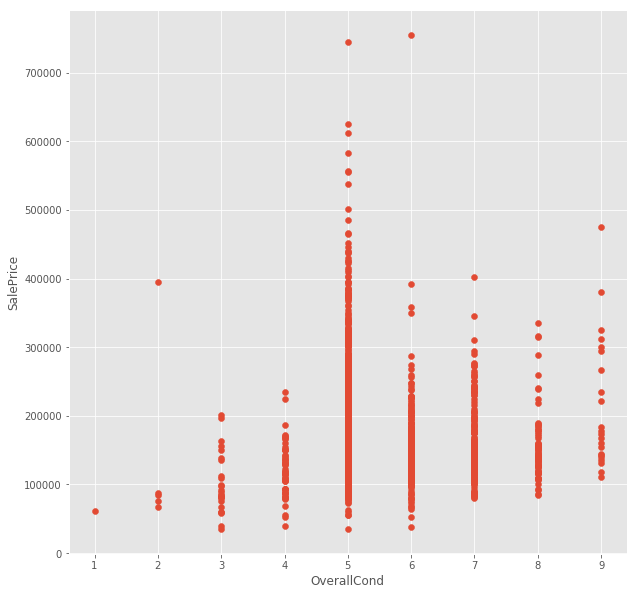

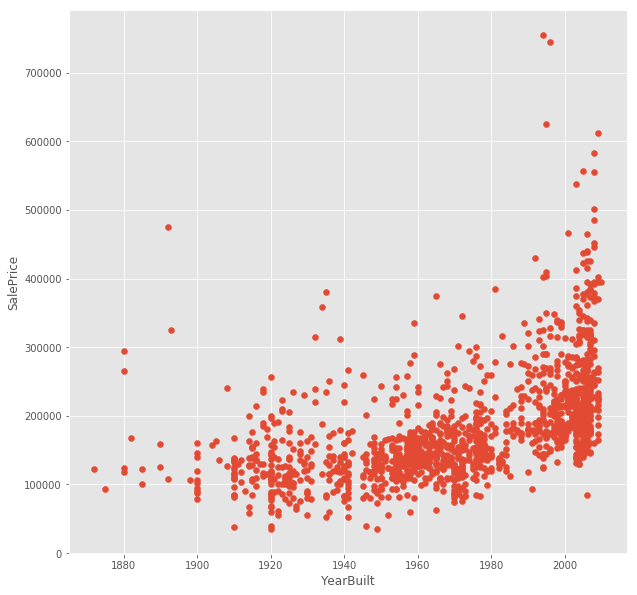

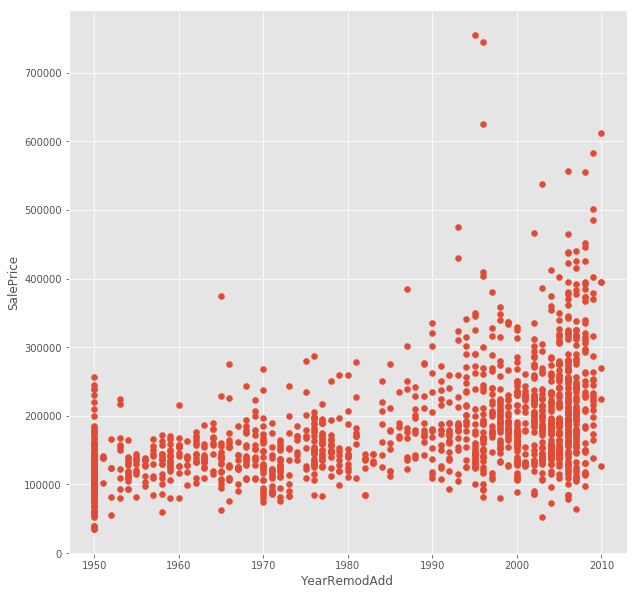

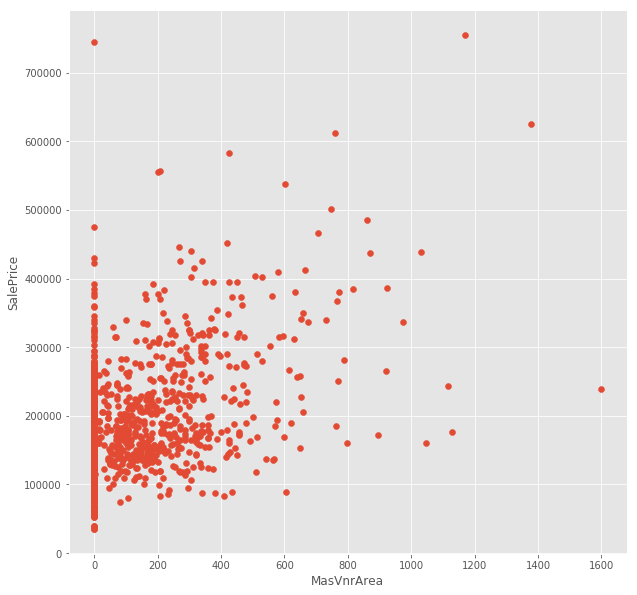

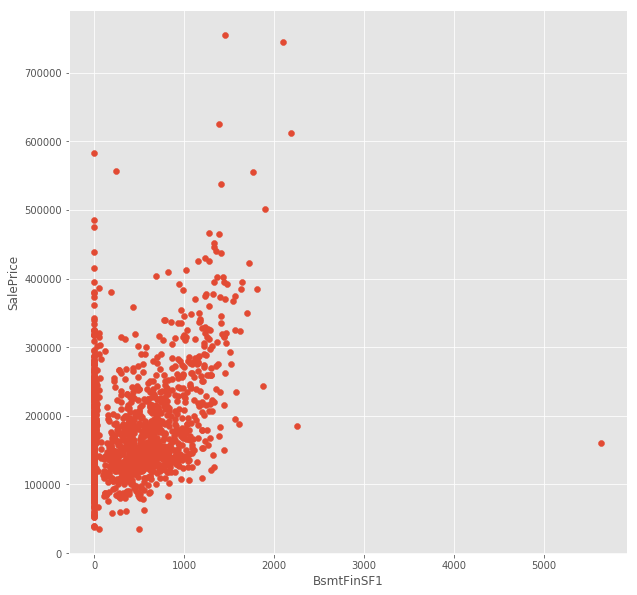

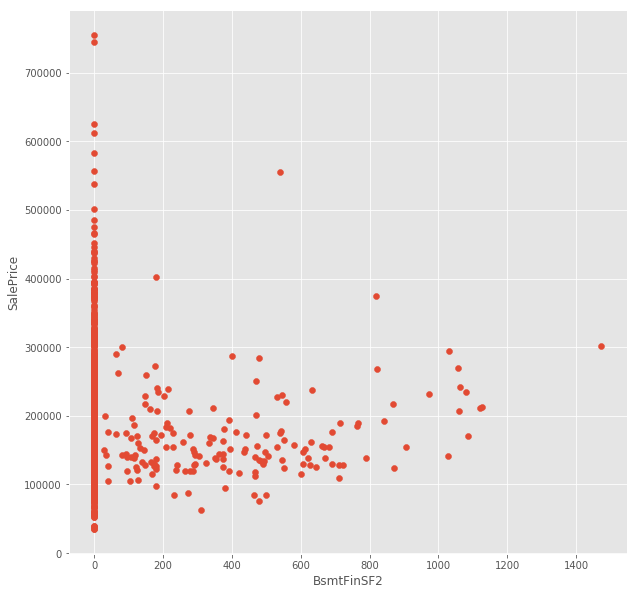

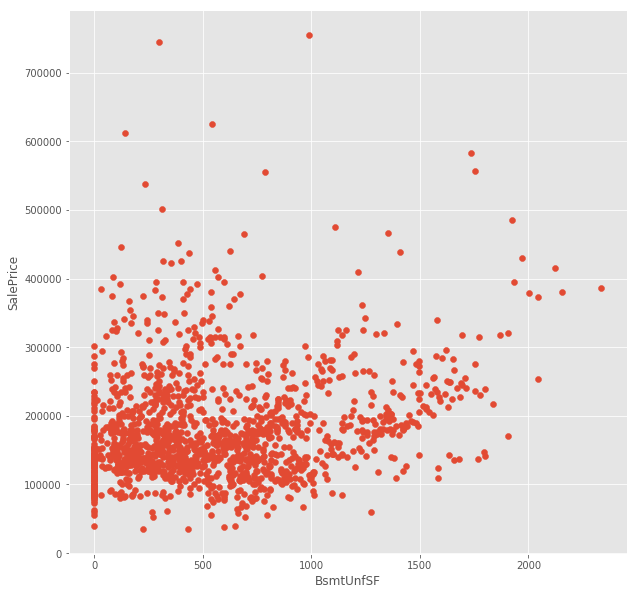

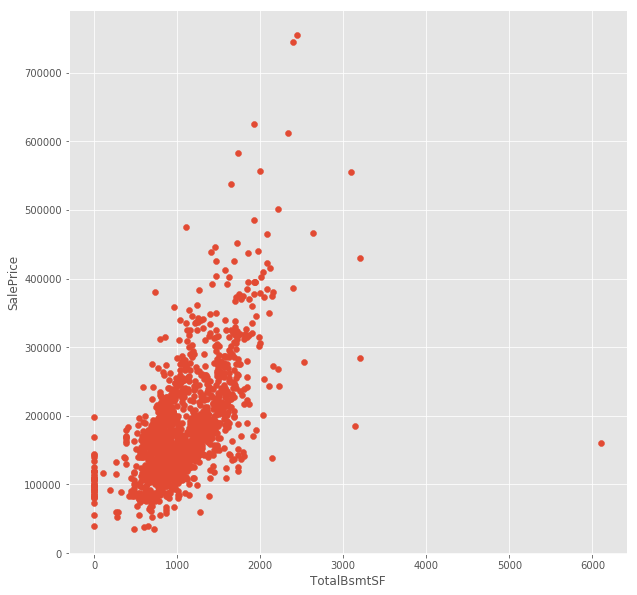

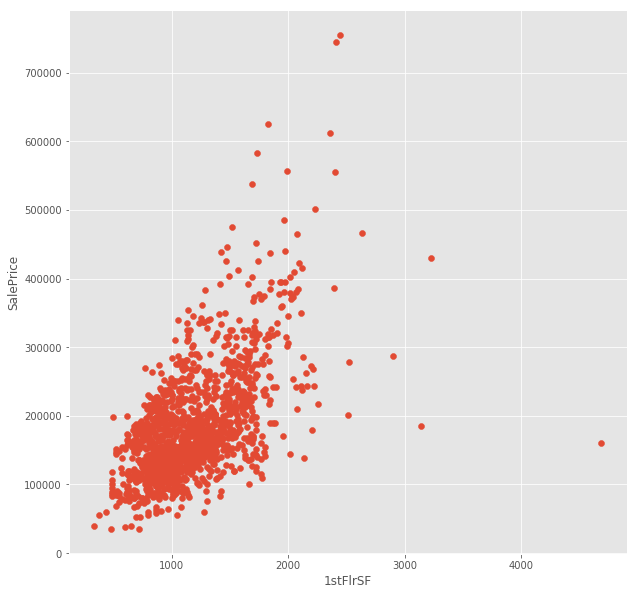

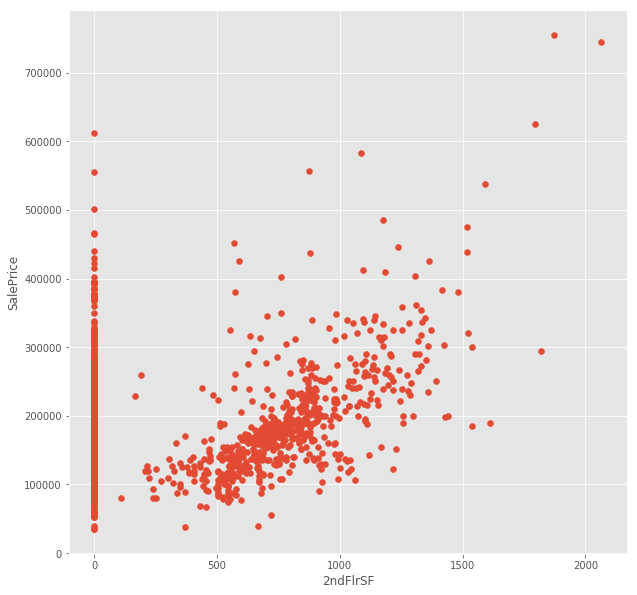

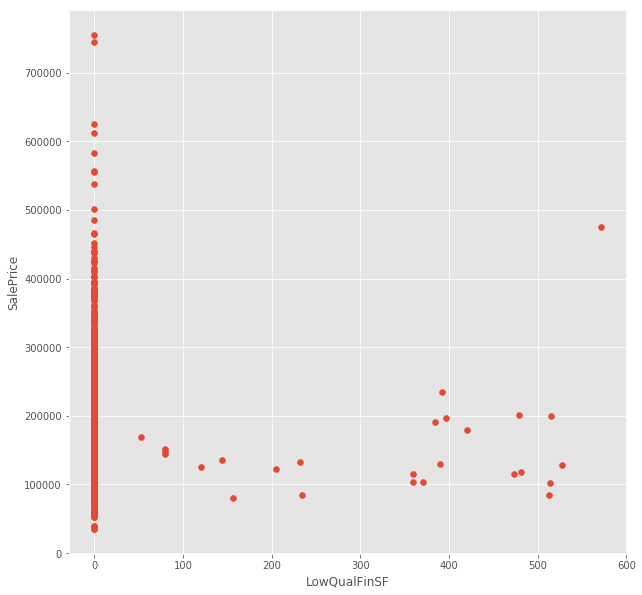

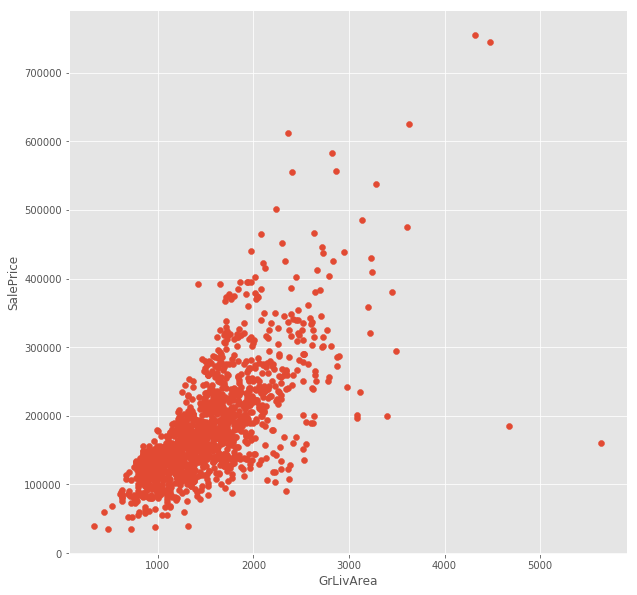

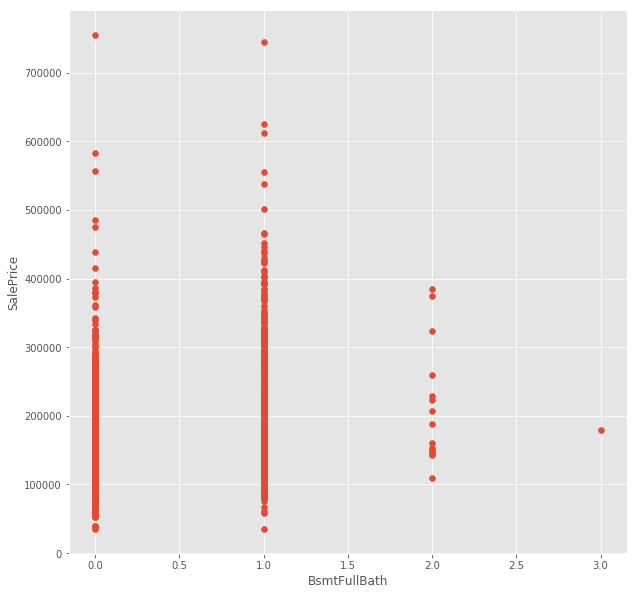

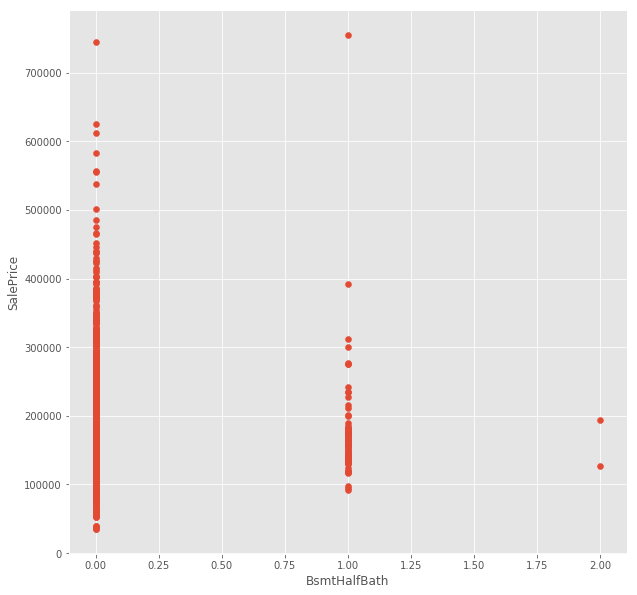

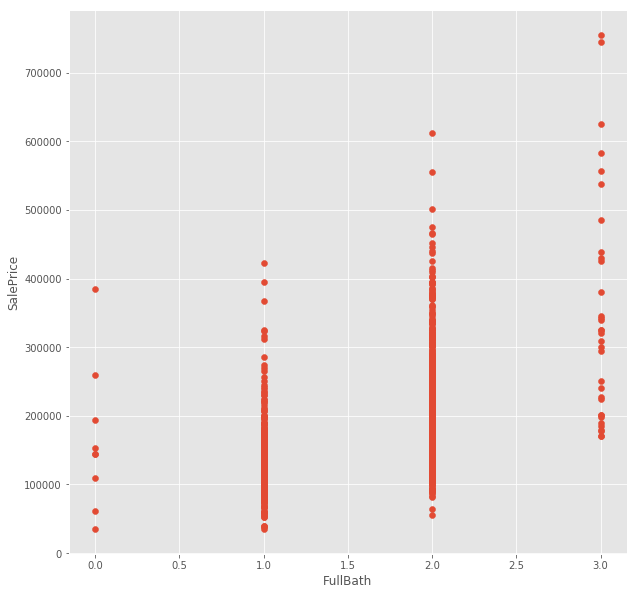

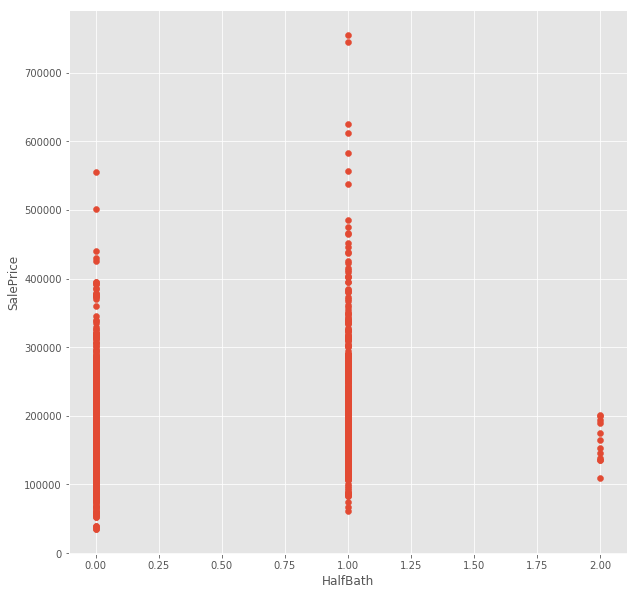

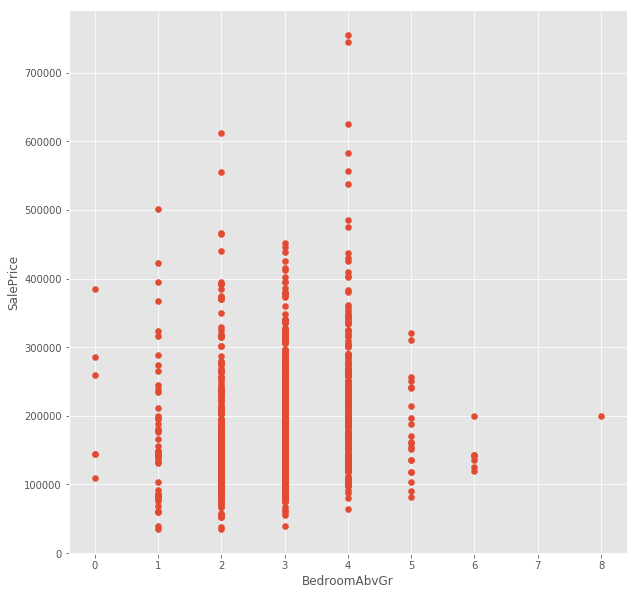

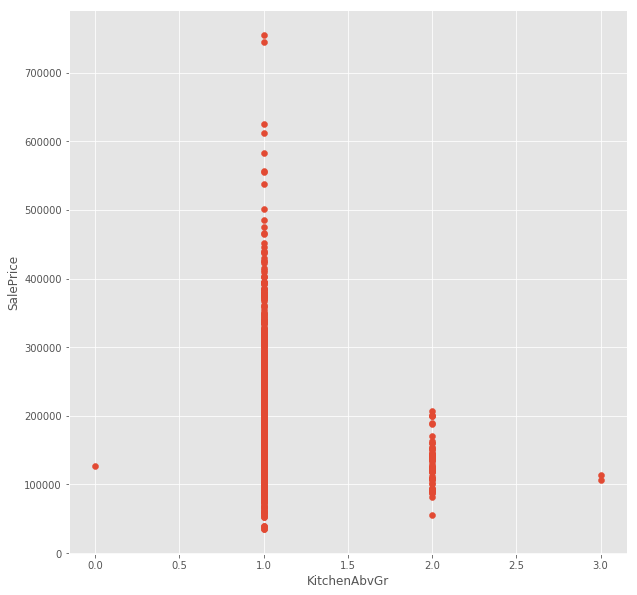

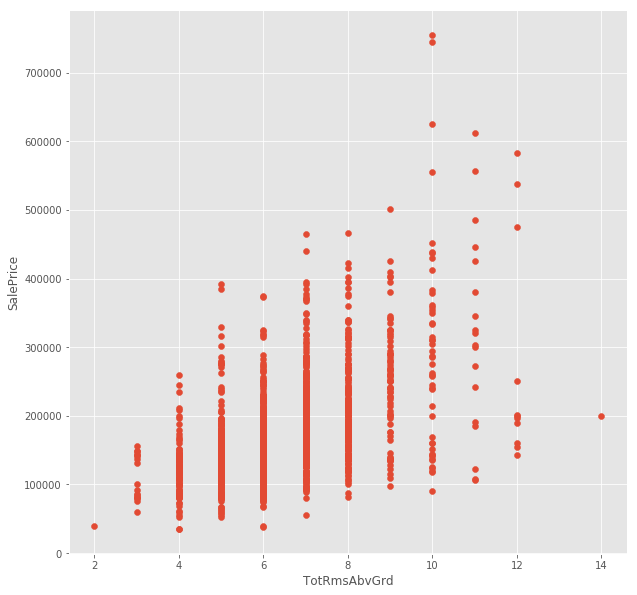

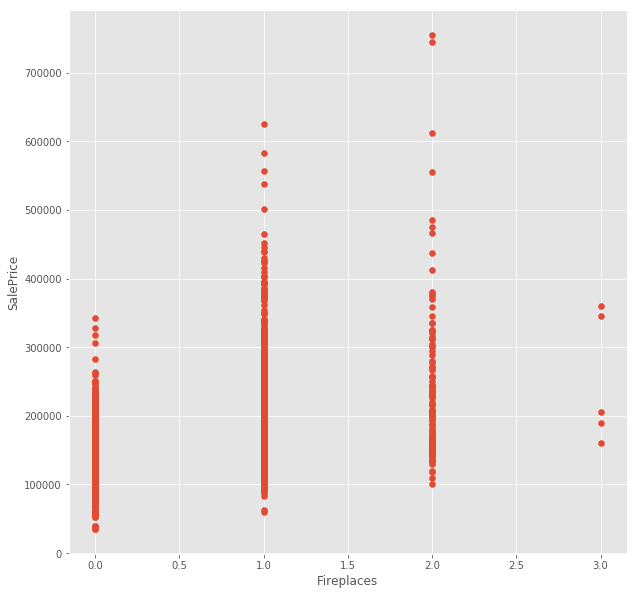

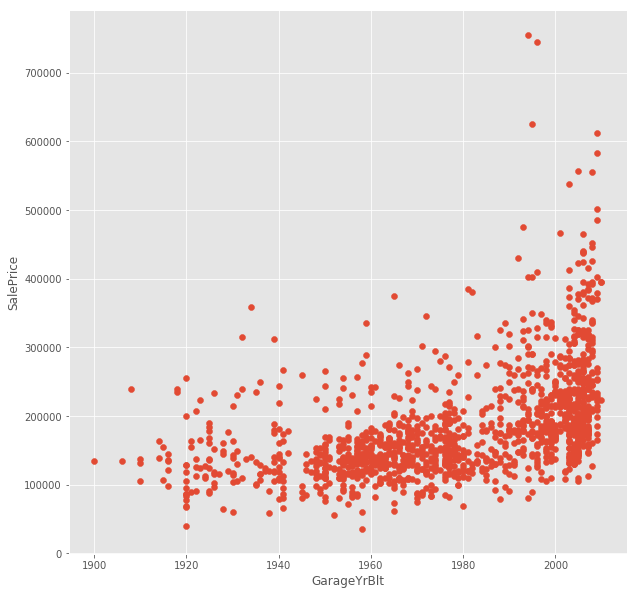

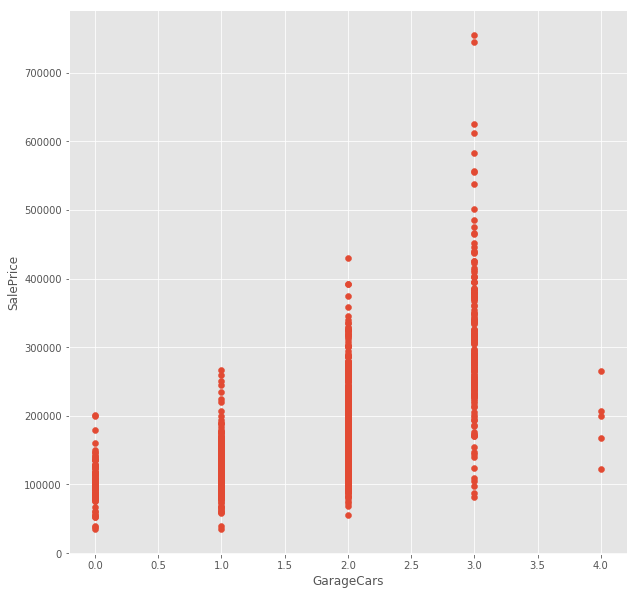

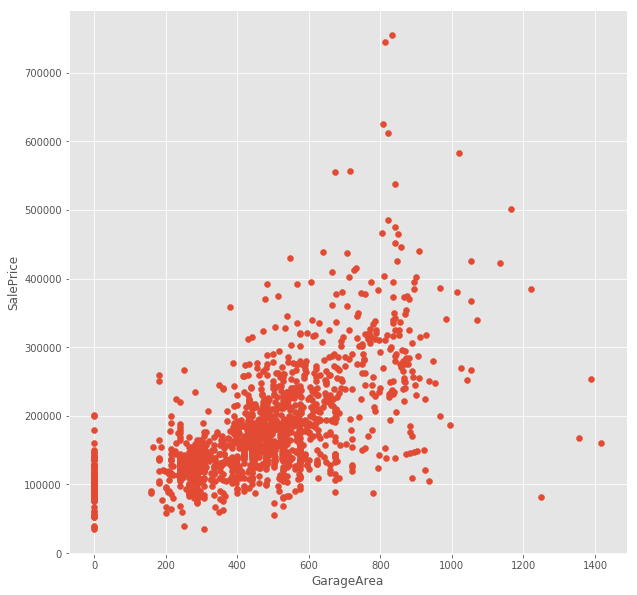

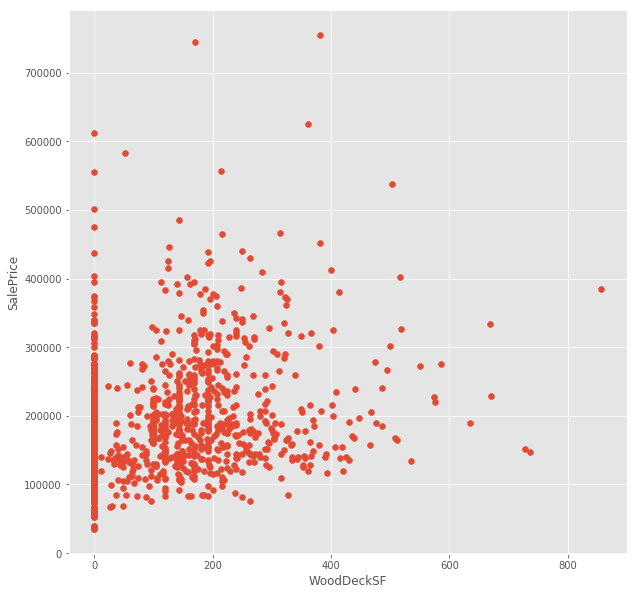

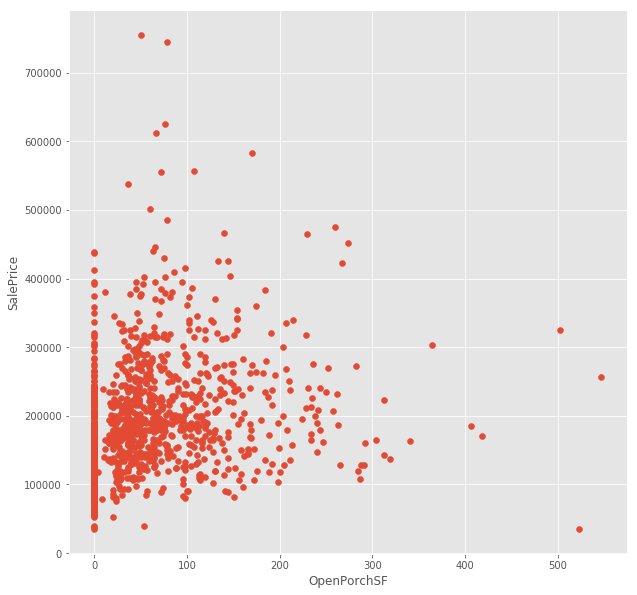

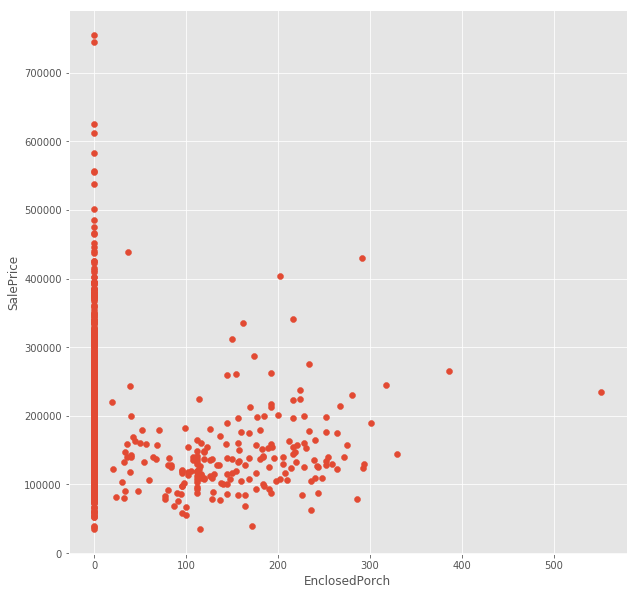

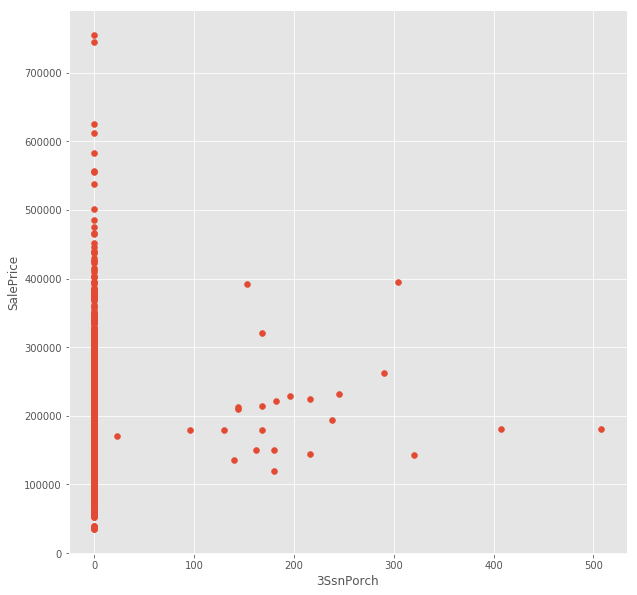

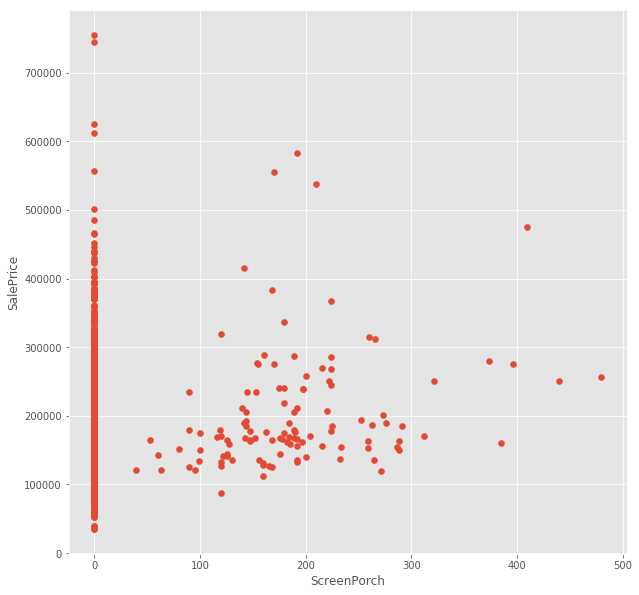

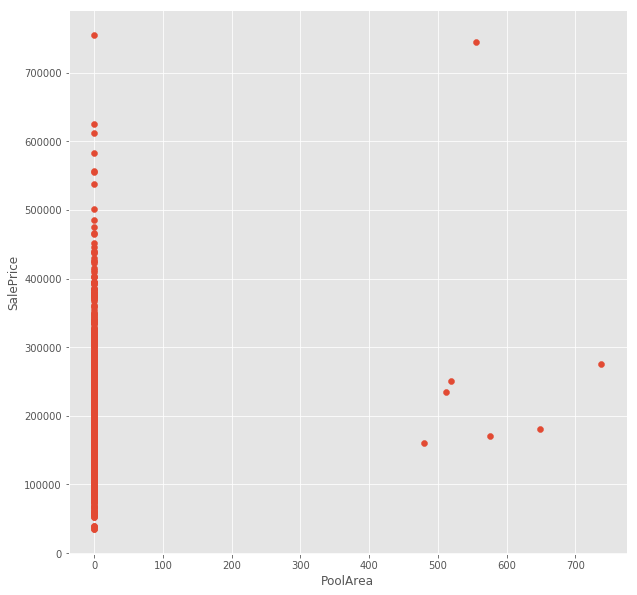

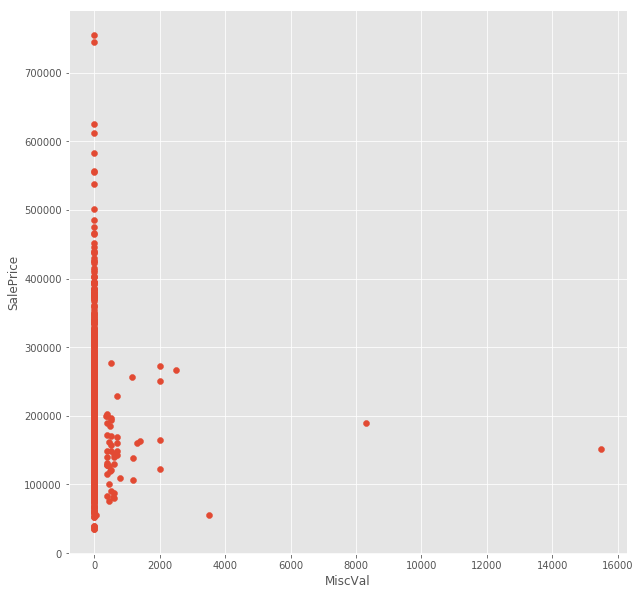

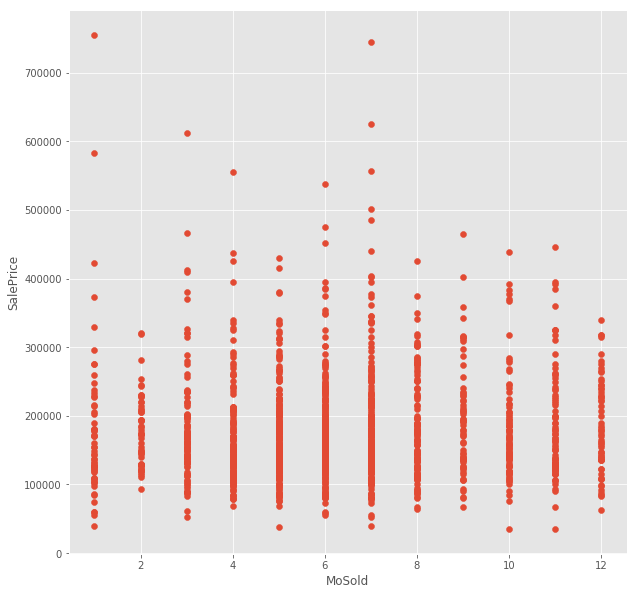

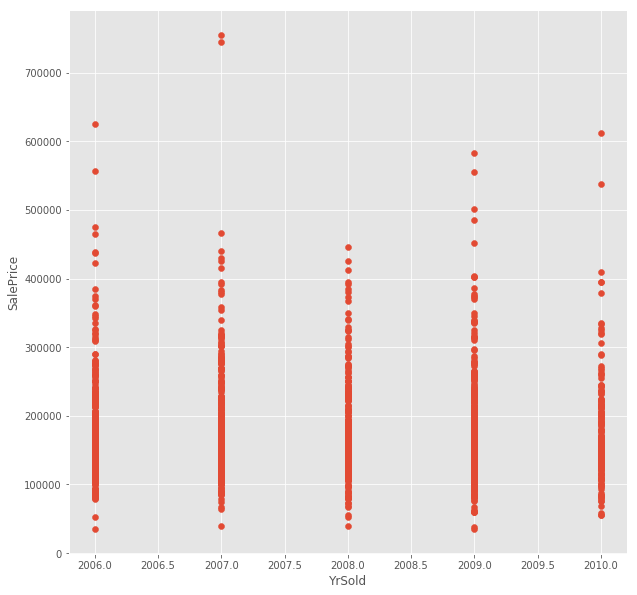

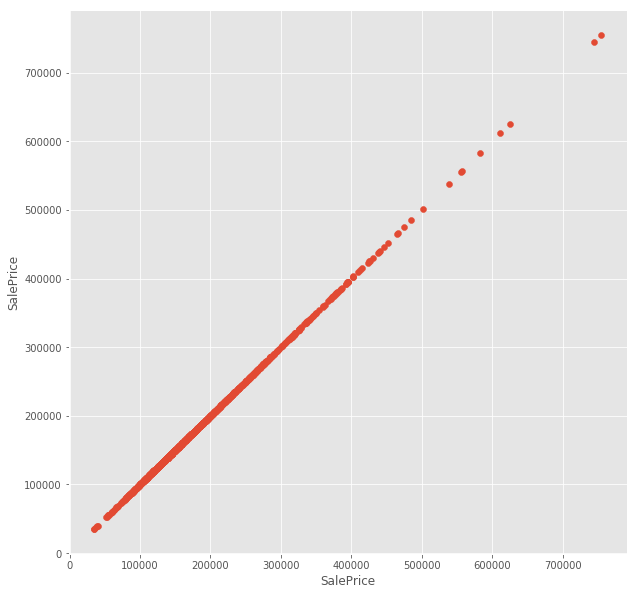

In [6]:
for col in train.dtypes[(train.dtypes!='object') & (train.dtypes!='category')].index:
    fig = plt.figure(figsize=(10,10))
    _ = plt.scatter(x=train[col], y=train['SalePrice'])
    _ = plt.xlabel(col)
    _ = plt.ylabel('SalePrice')
    _ = plt.show()

In [7]:
# Removing outliers
train = train[train['LotFrontage'] < 250]
train = train[train['BsmtFinSF1'] < 5000]
train = train[train['TotalBsmtSF'] < 6000]
train = train[train['1stFlrSF'] < 4000]
train = train[train['GrLivArea'] < 4600]

In [8]:
ntrain = train.shape[0]
full = pd.concat([train,holdout], ignore_index=True, sort=False)

In [9]:
full.isnull().mean()[full.isnull().any()==True].sort_values(ascending=False)

PoolQC          0.996989
MiscFeature     0.966127
Alley           0.927362
Fence           0.805043
SalePrice       0.549116
FireplaceQu     0.500565
LotFrontage     0.085435
GarageYrBlt     0.057207
GarageFinish    0.057207
GarageQual      0.057207
GarageCond      0.057207
GarageType      0.056455
BsmtCond        0.028604
BsmtExposure    0.028604
BsmtQual        0.028227
BsmtFinType2    0.027851
BsmtFinType1    0.027475
MasVnrType      0.008280
MasVnrArea      0.007904
MSZoning        0.001505
BsmtFullBath    0.000753
BsmtHalfBath    0.000753
Functional      0.000753
Utilities       0.000753
BsmtFinSF2      0.000376
BsmtUnfSF       0.000376
BsmtFinSF1      0.000376
TotalBsmtSF     0.000376
SaleType        0.000376
KitchenQual     0.000376
Exterior2nd     0.000376
Exterior1st     0.000376
GarageCars      0.000376
GarageArea      0.000376
Electrical      0.000376
dtype: float64

## Handling missing values

As described in the data description document, the missing values in the categorical features represents:<br>
- PoolQC: the house doesn't have a pool;
- MiscFeature: no miscellaneous features;
- Alley: no alley access;
- Fence: no fence;
- FireplaceQu: no fireplace;
- GarageCond, GarageQual, GarageFinish and GarageType: no garage;
- BsmtCond, BsmtExposure, BsmtQual, BsmtFinType1 and BsmtFinType2: no basement;
- MasVnrType: no masonry veneer.

In [10]:
# Before we fill the missing values with the string 'None', let's check if inconsistency is found in these features and treat them.

null_cols = ['PoolQC', 'MiscFeature', 'FireplaceQu', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType',
             'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

check_cols = ['PoolArea', 'MiscVal', 'Fireplaces', 'GarageArea', 'GarageArea', 'GarageArea', 'GarageArea',
              'TotalBsmtSF', 'TotalBsmtSF', 'TotalBsmtSF', 'TotalBsmtSF', 'TotalBsmtSF', 'MasVnrArea']

# Example: if a input with missing value in 'PoolQC' has a not null value in 'PoolArea', this imply that the house
#probably has a pool, so it is best to infer the missing value than imply that the house doesn't have a pool.
for n, c in zip(null_cols, check_cols):
    filtered = full[(full[n].isnull()) & (full[c]!=0)][c]
    if len(filtered) != 0:
        idx = filtered.index
        for i in idx:
            full.loc[i, n] = full[n].mode()[0]

            
# Once the inconsistency are treated, we can fill the missing values with the string 'None' without uncertainty.
null_cols += ['Alley', 'Fence']

for col in null_cols:
    full[col].fillna('None', inplace=True)

In [11]:
full.isnull().mean()[full.isnull().any()==True].sort_values(ascending=False)

SalePrice       0.549116
LotFrontage     0.085435
GarageYrBlt     0.057207
MasVnrArea      0.007904
MSZoning        0.001505
Functional      0.000753
BsmtHalfBath    0.000753
BsmtFullBath    0.000753
Utilities       0.000753
KitchenQual     0.000376
Electrical      0.000376
SaleType        0.000376
BsmtUnfSF       0.000376
BsmtFinSF2      0.000376
BsmtFinSF1      0.000376
GarageCars      0.000376
Exterior2nd     0.000376
Exterior1st     0.000376
GarageArea      0.000376
TotalBsmtSF     0.000376
dtype: float64

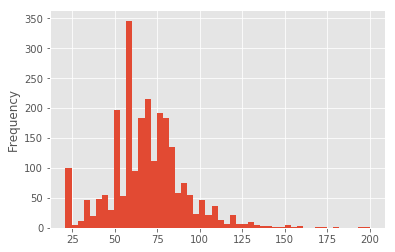

In [12]:
full['LotFrontage'].plot(kind='hist', bins=50)

In [13]:
# The 'LotFrontage' variable is skewed to the right, so it is best to infer the missing values with the median.
full['LotFrontage'].fillna(full['LotFrontage'].median(), inplace=True)

# Check inconsistency again.
cols1 = ['MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageArea']
check_cols1 = ['MasVnrType', 'BsmtQual', 'BsmtQual', 'GarageQual', 'BsmtQual', 'BsmtQual', 'GarageQual']

for n, c in zip(cols1, check_cols1):
    filtered = full[(full[n].isnull()) & (full[c]!='None')][c]
    if len(filtered) != 0:
        idx = filtered.index
        for i in idx:
            full.loc[i, n] = full[n].median()

# Once inconsistency treated, fill the missing values with 0 as the house doesn't have the feature.
for col in cols1:
    full[col].fillna(0, inplace=True)
    
    
cols2 = ['MSZoning', 'BsmtFullBath', 'BsmtHalfBath', 'Utilities', 'Functional', 'Electrical', 'KitchenQual',
         'SaleType','Exterior1st', 'Exterior2nd', 'GarageYrBlt']
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [14]:
full.isnull().mean()[full.isnull().any()==True].sort_values(ascending=False)

SalePrice    0.549116
dtype: float64

- Categorize 'YearBuilt', 'YearRemodAdd' and 'GarageYrBlt' features

In [15]:
full['YearBuilt'].min()
full['YearBuilt'].max()

1872

2010

In [16]:
# Categorize 'YearBuilt'
cut_yrblt = [1870, 1890, 1910, 1930, 1950, 1970, 1990, 2010]
label_yrblt = ['1870-1890', '1891-1910', '1911-1930', '1931-1950', '1951-1970', '1971-1990', '1991-2010']

full['YearBuilt_categories'] = pd.cut(full['YearBuilt'], cut_yrblt, labels=label_yrblt)

In [17]:
full['YearRemodAdd'].min()
full['YearRemodAdd'].max()

1950

2010

In [18]:
# Categorize 'YearRemoddAdd'
cut_yrremod = [1949, 1960, 1970, 1980, 1990, 2000, 2010]
label_yrremod = ['1950-1960', '1961-1970', '1971-1980', '1981-1990', '1991-2000', '2001-2010']

full['YearRemodAdd_categories'] = pd.cut(full['YearRemodAdd'], cut_yrremod, labels=label_yrremod)

In [19]:
full['GarageYrBlt'].value_counts().sort_index().head()
full['GarageYrBlt'].value_counts().sort_index().tail()

1895.0    1
1896.0    1
1900.0    6
1906.0    1
1908.0    1
Name: GarageYrBlt, dtype: int64

2007.0    113
2008.0     60
2009.0     28
2010.0      5
2207.0      1
Name: GarageYrBlt, dtype: int64

In [20]:
# A inconsistency was found in one entry in the 'GarageYrBlt' variable, so let's check it out.
full[full['GarageYrBlt']==2207][['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']]

,YearBuilt,YearRemodAdd,GarageYrBlt
2330,2006,2007,2207.0


In [21]:
# It seems that was a typo and the entry should've been 2007.
full.loc[2330, 'GarageYrBlt'] = 2007

In [22]:
# Categorize 'GarageYrBlt'
cut_yrgarage = [1890, 1910, 1930, 1950, 1970, 1990, 2010]
label_yrgarage = ['1890-1910', '1911-1930', '1931-1950', '1951-1970', '1971-1990', '1991-2010']

full['GarageYrBlt_categories'] = pd.cut(full['GarageYrBlt'], cut_yrgarage, labels=label_yrgarage)

In [23]:
# Remove the now unnecessary columns.
full.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [24]:
# Pass some variables to categorical.
full['MoSold'] = full['MoSold'].astype('str')
full['YrSold'] = full['YrSold'].astype('str')
full['MSSubClass'] = full['MSSubClass'].astype('str')

In [25]:
# Check the categorical variables out.
for col in full.dtypes[(full.dtypes=='object') | (full.dtypes=='category')].index:
    full[col].value_counts()

20     979
60     504
50     271
120    162
30     133
70     123
160    120
90     104
80      98
190     58
85      42
75      22
45      18
180     17
40       5
150      1
Name: MSSubClass, dtype: int64

RL         2037
RM          441
FV          131
C (all)      25
RH           23
Name: MSZoning, dtype: int64

Pave    2646
Grvl      11
Name: Street, dtype: int64

None    2464
Grvl     117
Pave      76
Name: Alley, dtype: int64

Reg    1785
IR1     800
IR2      60
IR3      12
Name: LotShape, dtype: int64

Lvl    2393
HLS     115
Bnk     108
Low      41
Name: LandContour, dtype: int64

AllPub    2657
Name: Utilities, dtype: int64

Inside     1997
Corner      448
CulDSac     127
FR2          71
FR3          14
Name: LotConfig, dtype: int64

Gtl    2542
Mod     107
Sev       8
Name: LandSlope, dtype: int64

NAmes      403
CollgCr    243
OldTown    235
Edwards    184
Somerst    174
NridgHt    165
Gilbert    135
Sawyer     125
SawyerW    116
NWAmes     103
BrkSide    101
Mitchel    101
Crawfor     93
IDOTRR      90
Timber      64
NoRidge     63
StoneBr     46
SWISU       46
MeadowV     35
BrDale      30
ClearCr     29
Blmngtn     25
NPkVill     21
Veenker     20
Blueste     10
Name: Neighborhood, dtype: int64

Norm      2288
Feedr      149
Artery      90
RRAn        48
PosN        28
RRAe        26
PosA        15
RRNn         8
RRNe         5
Name: Condition1, dtype: int64

Norm      2630
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
Name: Condition2, dtype: int64

1Fam      2196
TwnhsE     205
Duplex     104
Twnhs       93
2fmCon      59
Name: BldgType, dtype: int64

1Story    1342
2Story     787
1.5Fin     296
SLvl       107
SFoyer      76
2.5Unf      23
1.5Unf      18
2.5Fin       8
Name: HouseStyle, dtype: int64

Gable      2104
Hip         504
Gambrel      22
Flat         13
Mansard      11
Shed          3
Name: RoofStyle, dtype: int64

CompShg    2624
Tar&Grv      18
WdShngl       7
WdShake       6
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

VinylSd    958
MetalSd    419
HdBoard    380
Wd Sdng    372
Plywood    184
CemntBd    118
BrkFace     78
WdShing     55
AsbShng     43
Stucco      38
BrkComm      6
AsphShn      2
CBlock       2
ImStucc      1
Stone        1
Name: Exterior1st, dtype: int64

VinylSd    949
MetalSd    417
Wd Sdng    356
HdBoard    346
Plywood    222
CmentBd    119
Wd Shng     76
BrkFace     44
Stucco      42
AsbShng     37
Brk Cmn     22
ImStucc     14
Stone        5
AsphShn      4
CBlock       3
Other        1
Name: Exterior2nd, dtype: int64

None       1627
BrkFace     773
Stone       238
BrkCmn       19
Name: MasVnrType, dtype: int64

TA    1628
Gd     895
Ex     100
Fa      34
Name: ExterQual, dtype: int64

TA    2313
Gd     265
Fa      64
Ex      12
Po       3
Name: ExterCond, dtype: int64

PConc     1201
CBlock    1094
BrkTil     303
Slab        44
Stone       11
Wood         4
Name: Foundation, dtype: int64

TA      1171
Gd      1078
Ex       249
Fa        87
None      72
Name: BsmtQual, dtype: int64

TA      2368
Gd       111
Fa       102
None      72
Po         4
Name: BsmtCond, dtype: int64

No      1748
Av       379
Gd       242
Mn       216
None      72
Name: BsmtExposure, dtype: int64

Unf     801
GLQ     765
ALQ     381
Rec     266
BLQ     231
LwQ     141
None     72
Name: BsmtFinType1, dtype: int64

Unf     2279
Rec       89
LwQ       76
None      72
BLQ       61
ALQ       46
GLQ       34
Name: BsmtFinType2, dtype: int64

GasA    2615
GasW      27
Grav       8
Wall       5
OthW       2
Name: Heating, dtype: int64

Ex    1376
TA     768
Gd     428
Fa      82
Po       3
Name: HeatingQC, dtype: int64

Y    2468
N     189
Name: CentralAir, dtype: int64

SBrkr    2426
FuseA     174
FuseF      48
FuseP       8
Mix         1
Name: Electrical, dtype: int64

TA    1359
Gd    1035
Ex     197
Fa      66
Name: KitchenQual, dtype: int64

Typ     2474
Min2      64
Min1      58
Mod       34
Maj1      17
Maj2       9
Sev        1
Name: Functional, dtype: int64

None    1330
Gd       685
TA       496
Fa        65
Po        41
Ex        40
Name: FireplaceQu, dtype: int64

Attchd     1545
Detchd      732
BuiltIn     162
None        150
Basment      32
2Types       22
CarPort      14
Name: GarageType, dtype: int64

Unf     1132
RFn      728
Fin      647
None     150
Name: GarageFinish, dtype: int64

TA      2356
None     150
Fa       122
Gd        21
Po         5
Ex         3
Name: GarageQual, dtype: int64

TA      2409
None     150
Fa        71
Po        13
Gd        11
Ex         3
Name: GarageCond, dtype: int64

Y    2393
N     207
P      57
Name: PavedDrive, dtype: int64

None    2646
Ex         7
Gd         2
Fa         2
Name: PoolQC, dtype: int64

None     2139
MnPrv     300
GdPrv     107
GdWo      100
MnWw       11
Name: Fence, dtype: int64

None    2566
Shed      83
Othr       4
Gar2       3
TenC       1
Name: MiscFeature, dtype: int64

6     449
7     412
5     352
4     257
8     214
3     208
10    159
9     152
2     125
11    125
1     112
12     92
Name: MoSold, dtype: int64

2007    628
2009    582
2008    570
2006    570
2010    307
Name: YrSold, dtype: int64

WD       2280
New       236
COD        76
ConLD      25
CWD        12
ConLI       8
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

Normal     2164
Partial     242
Abnorml     173
Family       44
Alloca       22
AdjLand      12
Name: SaleCondition, dtype: int64

1991-2010    1017
1951-1970     618
1971-1990     381
1911-1930     276
1931-1950     256
1891-1910      91
1870-1890      18
Name: YearBuilt_categories, dtype: int64

2001-2010    915
1950-1960    570
1991-2000    503
1971-1980    274
1961-1970    268
1981-1990    127
Name: YearRemodAdd_categories, dtype: int64

1991-2010    1235
1951-1970     584
1971-1990     460
1931-1950     211
1911-1930     147
1890-1910      20
Name: GarageYrBlt_categories, dtype: int64

In [26]:
# The 'Stree't and 'Utilities' columns have most of the values in just one categories, so we can safely drop these columns.
full.drop(['Street', 'Utilities'], axis=1, inplace=True)

**Label Encoding ordinal variables**

In [27]:
full['LotShape'] = full['LotShape'].map({'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4})
full['LandSlope'] = full['LandSlope'].map({'Sev': 1, 'Mod': 2, 'Gtl': 3})
full['LandContour'] = full['LandContour'].map({'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl': 4})
full['ExterQual'] = full['ExterQual'].map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
full['ExterCond'] = full['ExterCond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
full['BsmtQual'] = full['BsmtQual'].map({'None': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
full['BsmtCond'] = full['BsmtCond'].map({'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5})
full['HeatingQC'] = full['HeatingQC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
full['KitchenQual'] = full['KitchenQual'].map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
full['FireplaceQu'] = full['FireplaceQu'].map({'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6})
full['GarageQual'] = full['GarageQual'].map({'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6})
full['GarageCond'] = full['GarageCond'].map({'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6})
full['PoolQC'] = full['PoolQC'].map({'None': 1, 'Fa': 2, 'Gd': 3, 'Ex': 4})

In [28]:
categorical = full.select_dtypes(include=['object', 'category']).columns
numerical = full.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice'])

**Scaling numerical variables**

In [29]:
for col in numerical:
    full[col] = minmax_scale(full[col].astype(float))

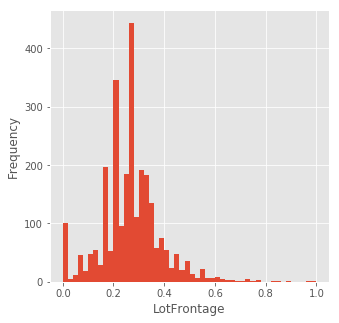

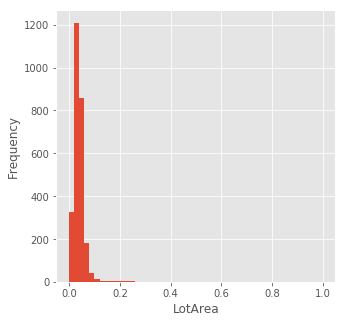

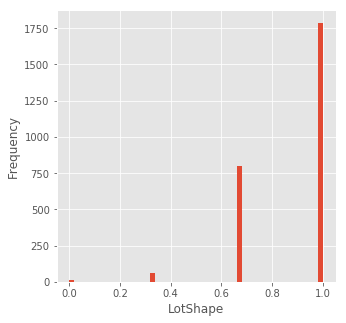

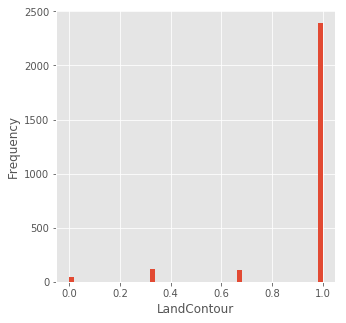

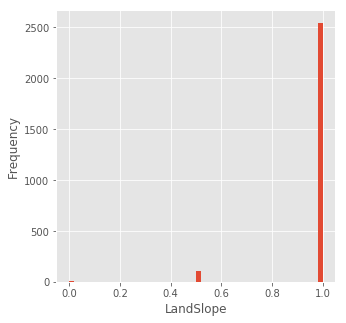

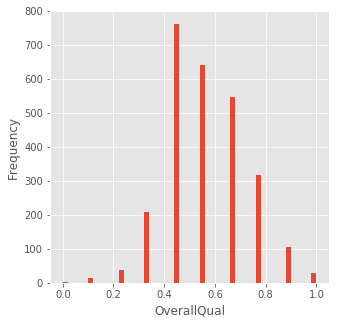

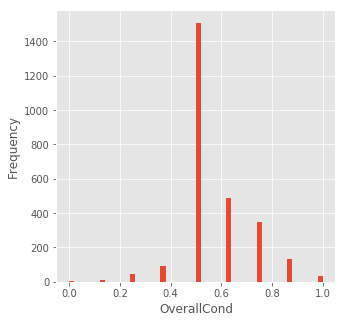

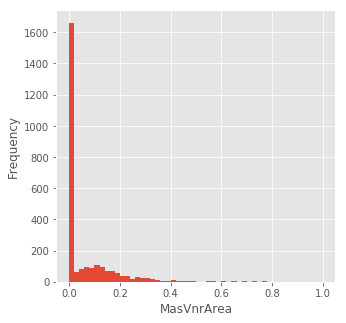

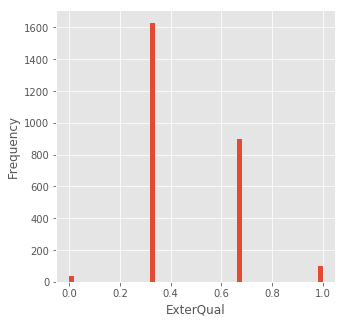

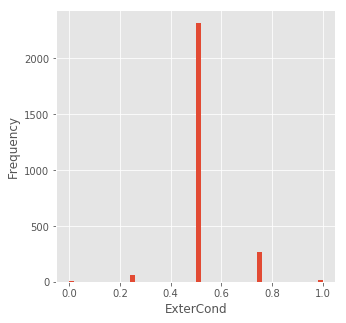

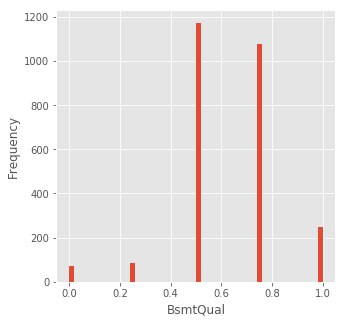

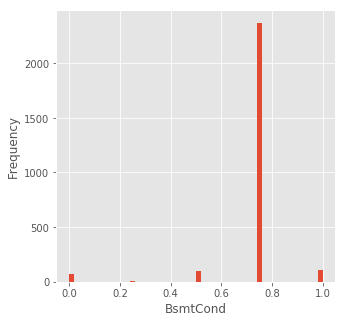

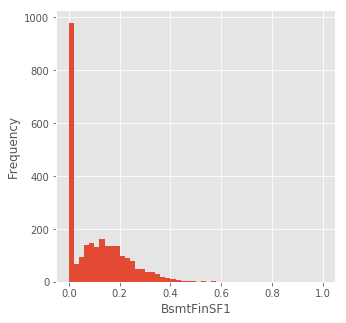

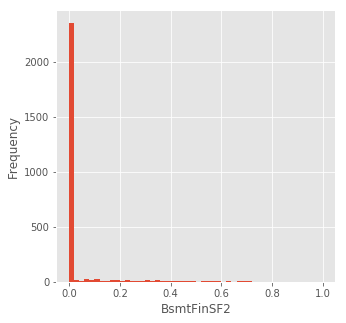

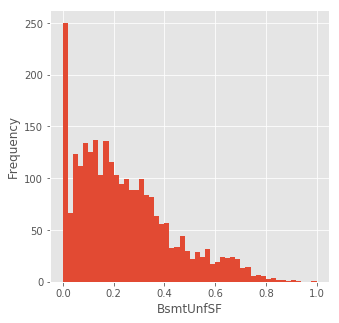

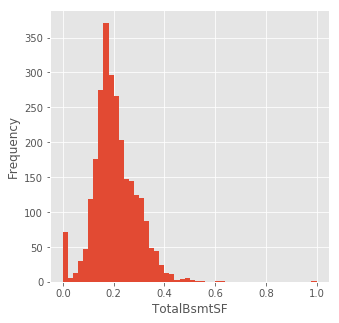

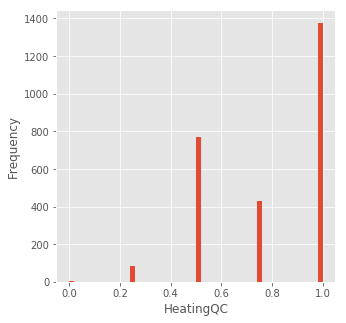

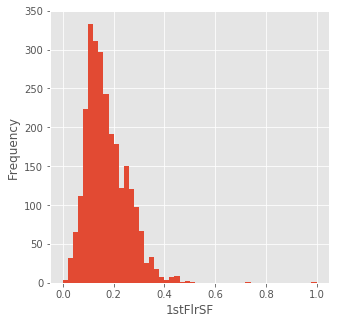

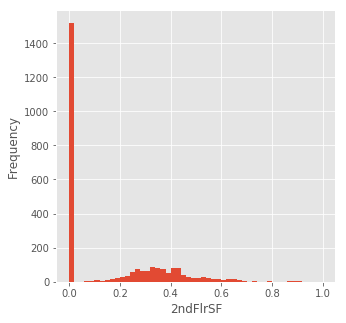

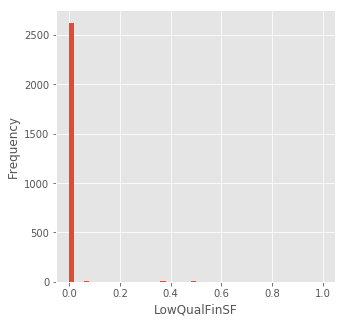

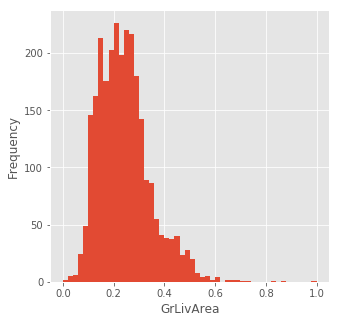

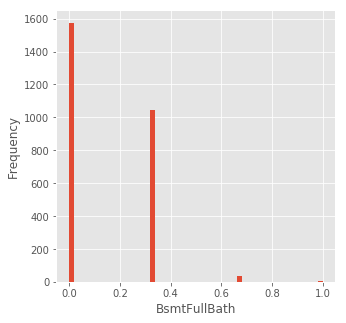

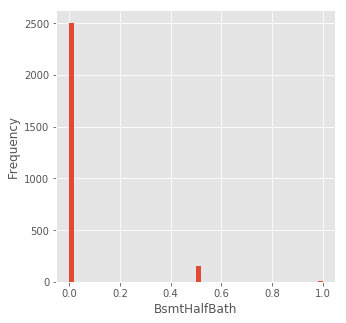

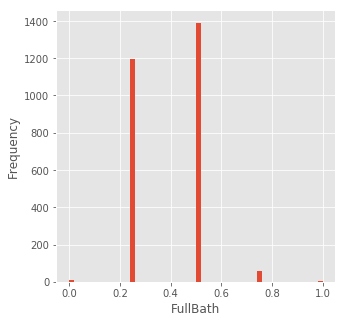

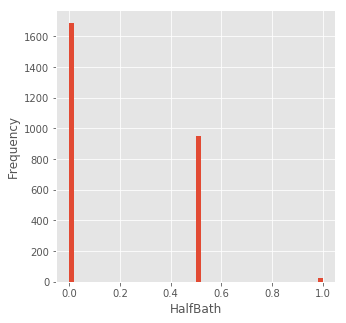

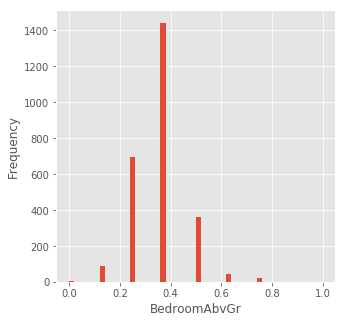

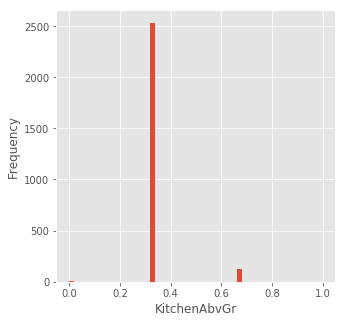

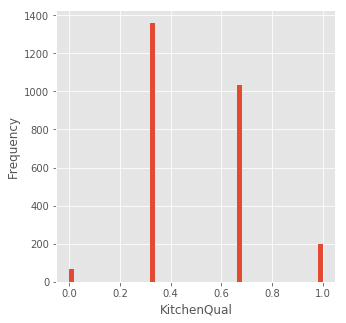

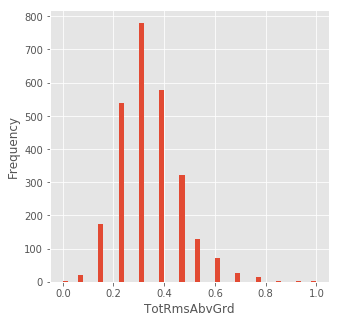

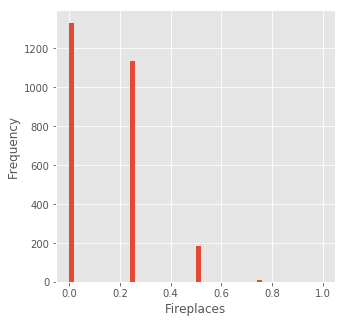

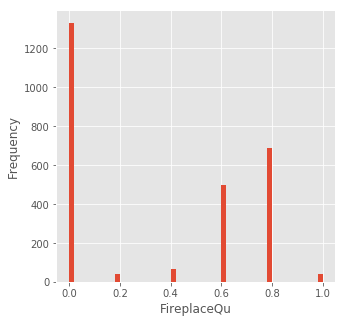

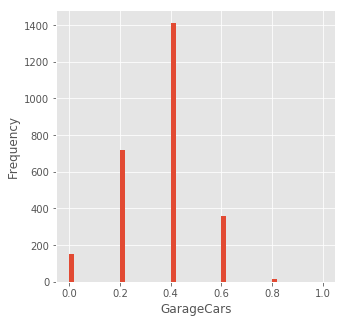

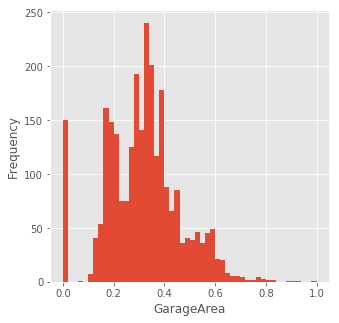

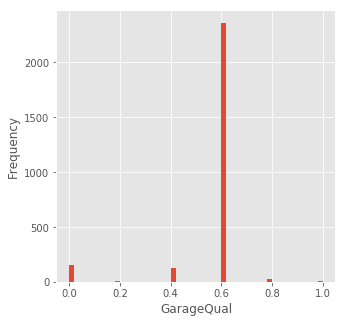

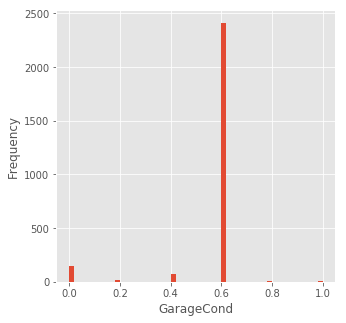

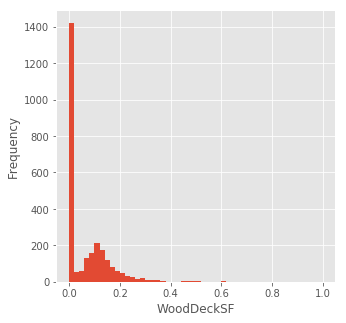

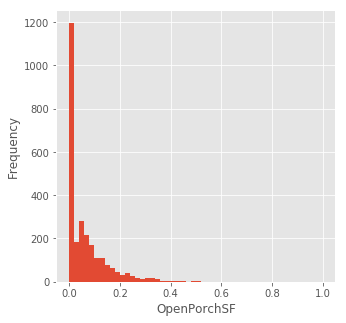

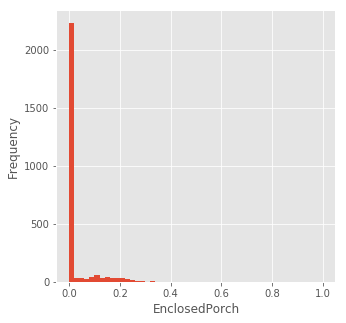

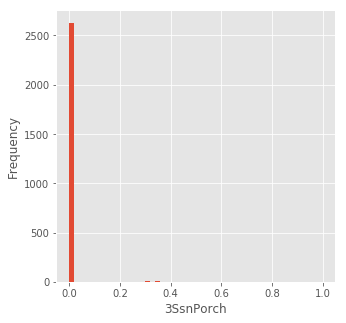

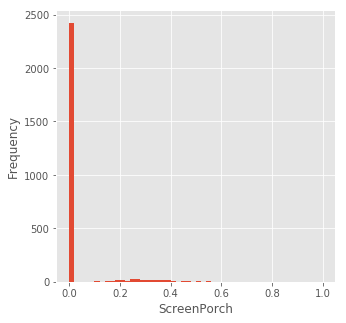

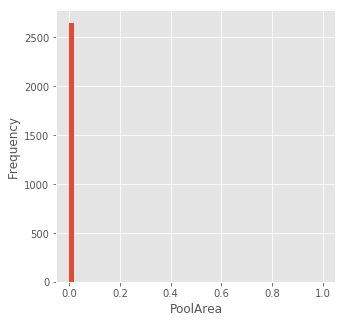

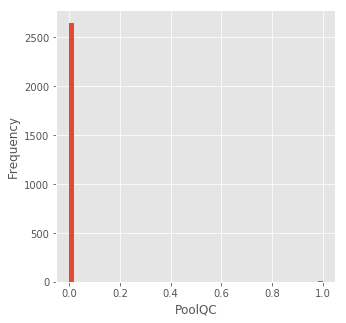

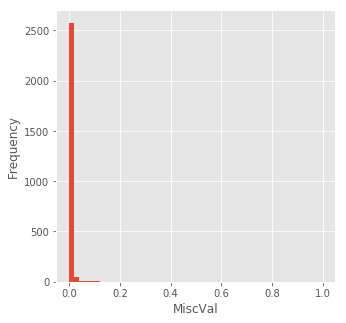

In [30]:
for col in numerical:
    fig = plt.figure(figsize=(5,5))
    _ = plt.hist(full[col], bins=50)
    _ = plt.xlabel(col)
    _ = plt.ylabel('Frequency')
    _ = plt.show()

In [31]:
full_numeric = full[numerical]
skewness = full_numeric.apply(lambda x: skew(x))
skewness_features = skewness[abs(skewness) >= 0.5].index
full[skewness_features] = np.log1p(full[skewness_features])

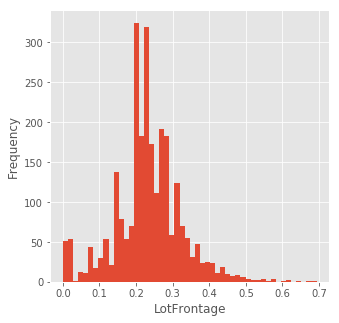

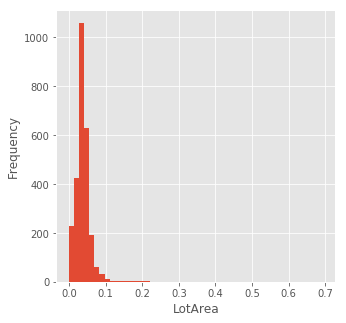

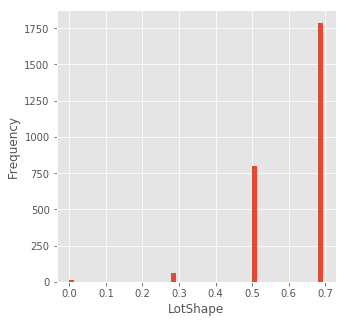

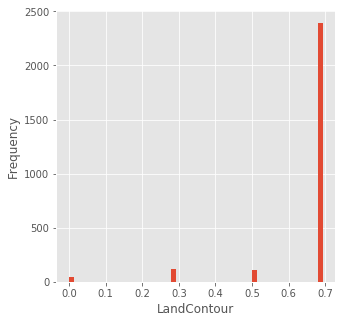

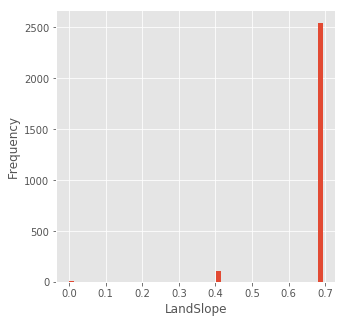

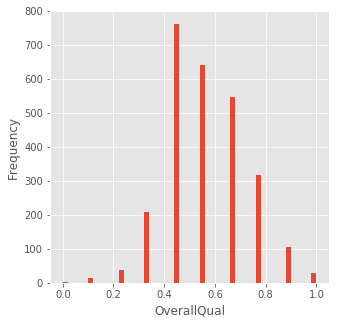

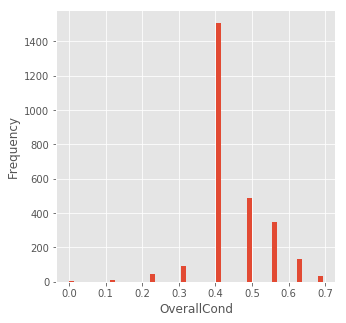

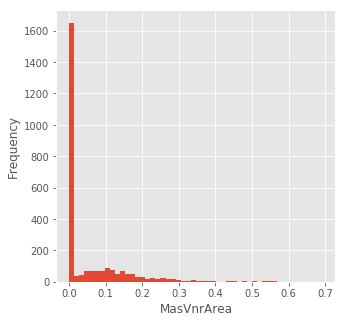

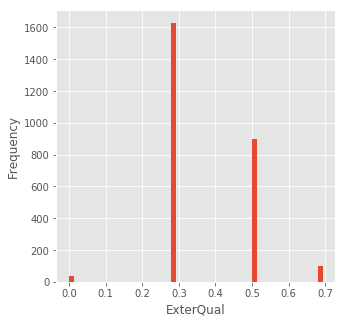

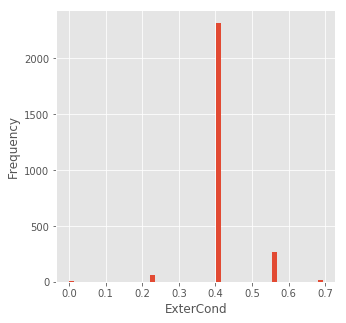

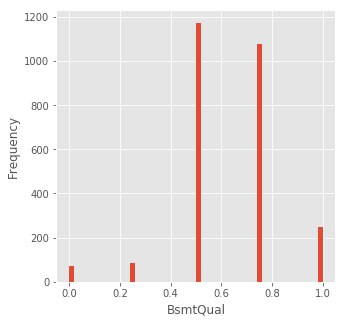

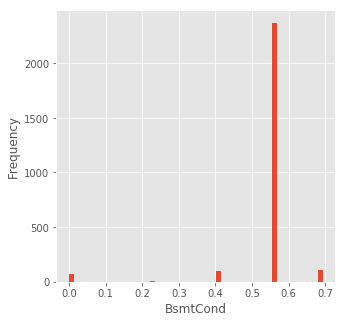

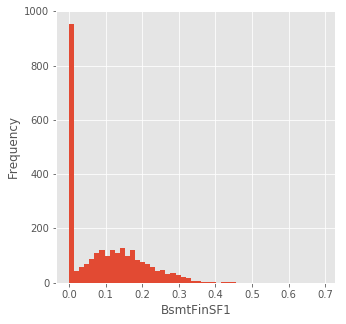

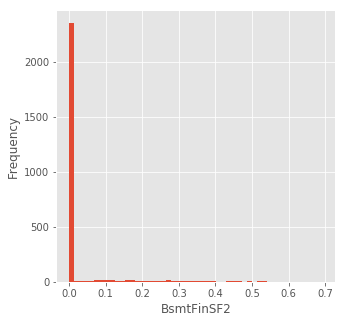

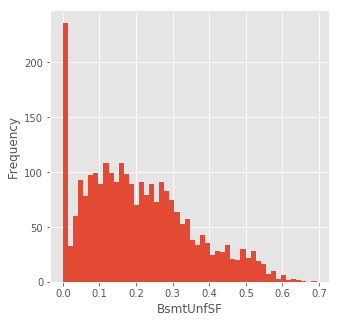

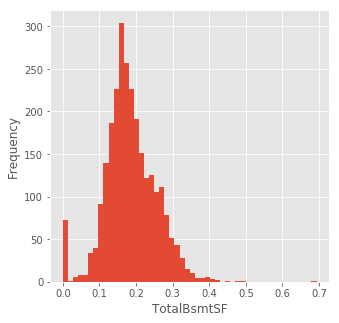

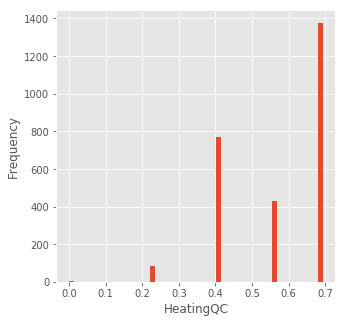

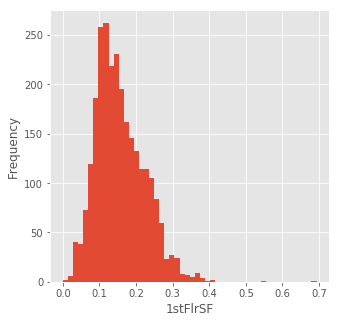

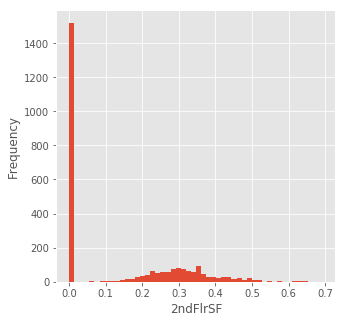

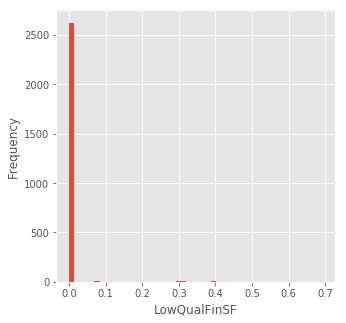

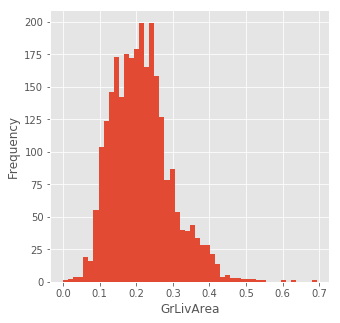

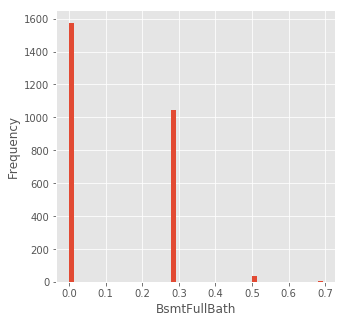

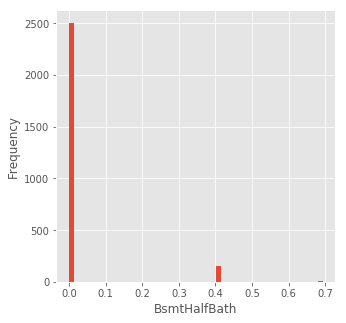

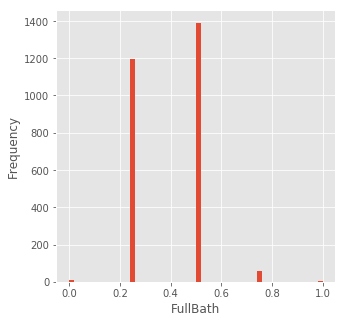

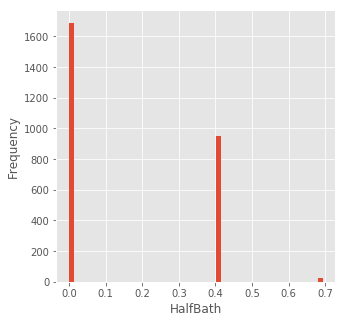

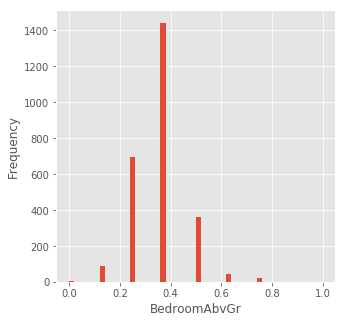

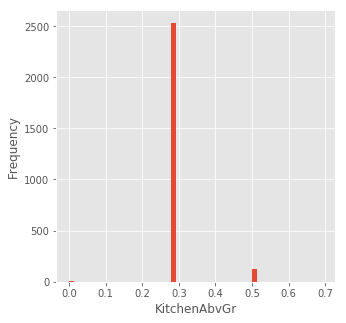

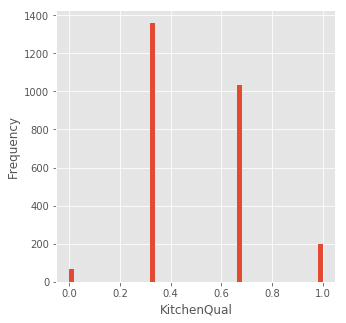

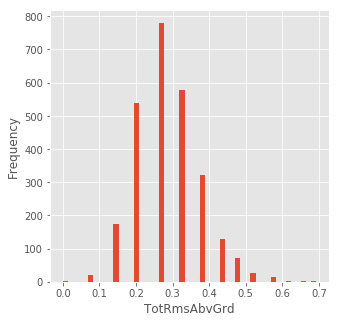

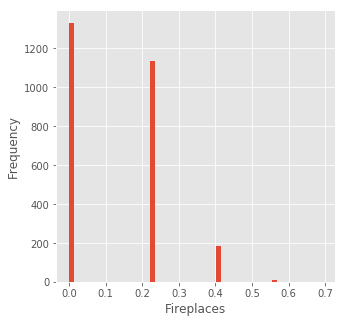

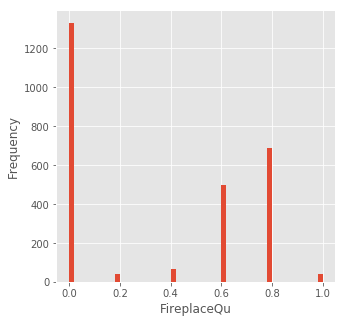

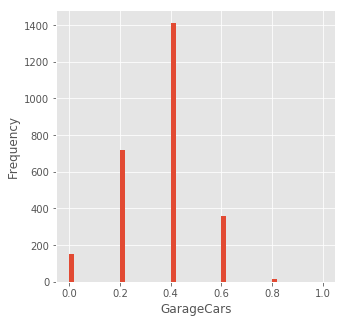

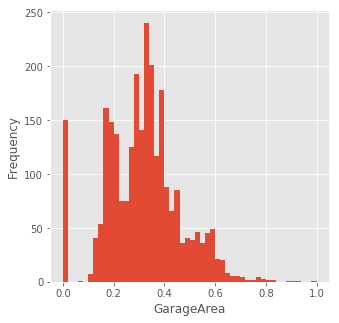

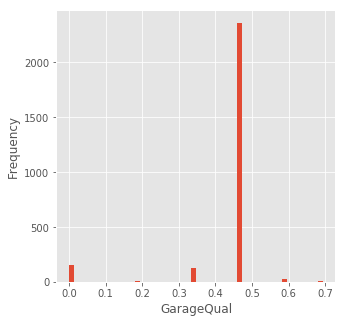

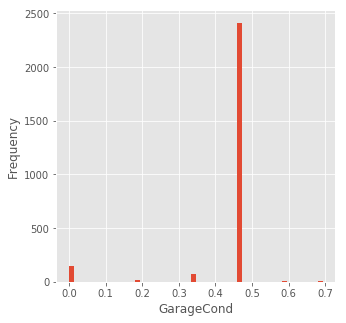

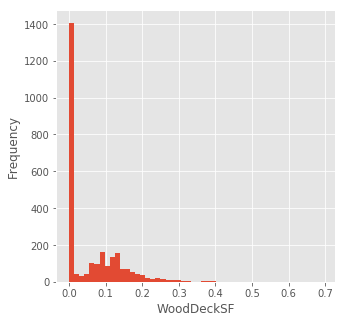

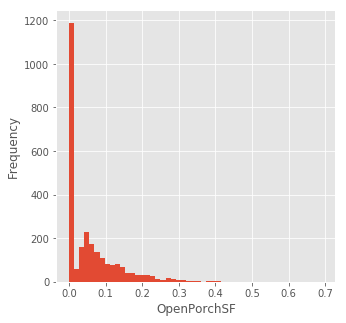

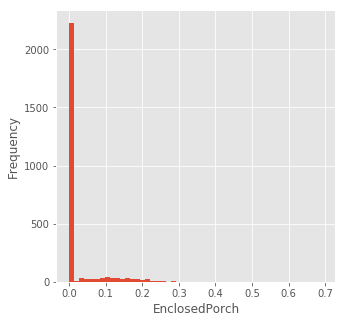

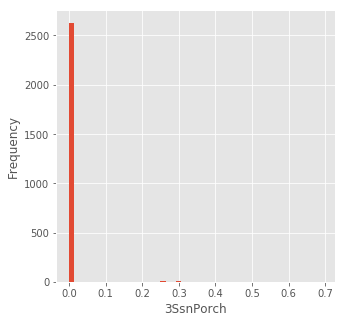

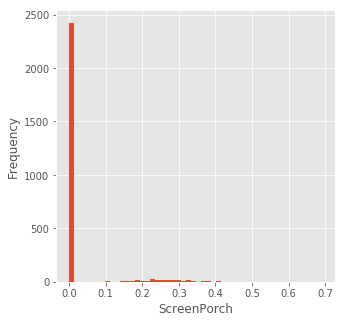

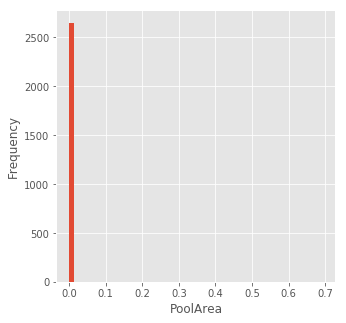

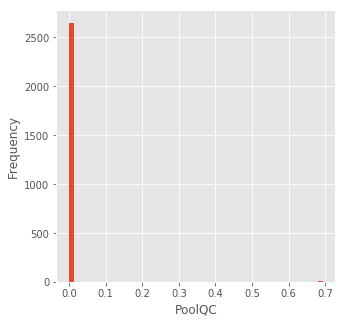

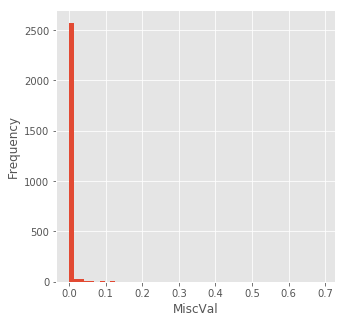

In [32]:
for col in numerical:
    fig = plt.figure(figsize=(5,5))
    _ = plt.hist(full[col], bins=50)
    _ = plt.xlabel(col)
    _ = plt.ylabel('Frequency')
    _ = plt.show()

In [33]:
full = pd.get_dummies(full)

full.drop(['Id', 'SalePrice'], axis=1, inplace=True)

holdout_id = holdout['Id'].copy()
holdout = full.iloc[ntrain:]
X = full.iloc[:ntrain]
y = train['SalePrice']

In [34]:
full.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,2657.0,0.233216,0.092398,0.0,0.197109,0.233149,0.284885,0.693147
LotArea,2657.0,0.038807,0.024926,0.0,0.028113,0.036936,0.045958,0.693147
LotShape,2657.0,0.625965,0.106686,0.0,0.510826,0.693147,0.693147,0.693147
LandContour,2657.0,0.657491,0.120892,0.0,0.693147,0.693147,0.693147,0.693147
LandSlope,2657.0,0.679475,0.067781,0.0,0.693147,0.693147,0.693147,0.693147
OverallQual,2657.0,0.566136,0.158386,0.0,0.444444,0.555556,0.666667,1.000000
OverallCond,2657.0,0.447057,0.087170,0.0,0.405465,0.405465,0.485508,0.693147
MasVnrArea,2657.0,0.056011,0.094711,0.0,0.000000,0.000000,0.095310,0.693147
ExterQual,2657.0,0.374426,0.128456,0.0,0.287682,0.287682,0.510826,0.693147
ExterCond,2657.0,0.417289,0.059930,0.0,0.405465,0.405465,0.405465,0.693147


## Testing models

In [35]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

- **Lasso**

In [43]:
from sklearn.linear_model import Lasso

alpha = [1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
y_log = np.log1p(y)

for a in alpha:
    lasso = Lasso(alpha=a, max_iter=10000)
    rmse = rmse_cv(lasso, X, y_log).mean()
    print('alpha: {0} ---------- rmse: {1}'.format(a, rmse))

alpha: 1e-05 ---------- rmse: 0.1303669383608528
alpha: 0.0001 ---------- rmse: 0.11990834361568872
alpha: 0.001 ---------- rmse: 0.11925581780578709
alpha: 0.01 ---------- rmse: 0.19824551552244193
alpha: 1 ---------- rmse: 0.4163193634356692
alpha: 5 ---------- rmse: 0.4163193634356692
alpha: 10 ---------- rmse: 0.4163193634356692


In [37]:
lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(X, y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X.columns)
lasso_cols = FI_lasso[FI_lasso['Feature Importance'].abs() > 0.01].index
lasso_cols

Index(['LotFrontage', 'OverallQual', 'OverallCond', 'BsmtQual', 'BsmtFinSF1',
       'TotalBsmtSF', 'HeatingQC', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'KitchenQual', 'FireplaceQu', 'GarageCars', 'GarageArea',
       'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MSZoning_C (all)',
       'MSZoning_FV', 'MSZoning_RM', 'LotConfig_CulDSac',
       'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_Norm', 'BldgType_1Fam',
       'BldgType_Twnhs', 'RoofStyle_Hip', 'Exterior1st_BrkFace',
       'Exterior1st_MetalSd', 'MasVnrType_Stone', 'Foundation_BrkTil',
       'BsmtExposure_Gd', 'BsmtFinType1_ALQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_Unf', 'Heating_GasW', 'CentralAir_N', 'Functional_Typ',
       'GarageType_None', 'PavedDrive_Y', 'YrSold_2009', 'SaleType_New',
       'SaleCondition_Abnorml', 'YearBuilt_categories_1

In [39]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X.columns)
for fi in np.arange(0, 0.2, 0.01):
    lasso_cols = FI_lasso[FI_lasso['Feature Importance'].abs() > fi].index
    rmse = rmse_cv(lasso, X[lasso_cols], y_log).mean()
    print('fi: {0} -------- rmse: {1}'.format(round(fi, 2), rmse))

fi: 0.0 -------- rmse: 0.11855133522637865
fi: 0.01 -------- rmse: 0.11700153768836627
fi: 0.02 -------- rmse: 0.11696189991849162
fi: 0.03 -------- rmse: 0.11725368455332755
fi: 0.04 -------- rmse: 0.1185795968346028
fi: 0.05 -------- rmse: 0.12804354537519813
fi: 0.06 -------- rmse: 0.13452482705593008
fi: 0.07 -------- rmse: 0.1386631679218044
fi: 0.08 -------- rmse: 0.14377777664099298
fi: 0.09 -------- rmse: 0.145641581035928
fi: 0.1 -------- rmse: 0.14905239839745163
fi: 0.11 -------- rmse: 0.15389462543536733
fi: 0.12 -------- rmse: 0.1554384907150538
fi: 0.13 -------- rmse: 0.1554384907150538
fi: 0.14 -------- rmse: 0.1554384907150538
fi: 0.15 -------- rmse: 0.1554384907150538
fi: 0.16 -------- rmse: 0.16288983498282622
fi: 0.17 -------- rmse: 0.16288983498282622
fi: 0.18 -------- rmse: 0.1749957538794686
fi: 0.19 -------- rmse: 0.1749957538794686


In [40]:
lasso_cols = FI_lasso[FI_lasso['Feature Importance'].abs() > 0.02].index

In [41]:
lasso.fit(X[lasso_cols], y_log)

preds = np.expm1(lasso.predict(holdout[lasso_cols]))

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
# sub = pd.DataFrame()
# sub['Id'] = holdout_id
# sub['SalePrice'] = preds
# sub.to_csv('submission.csv',index=False)
#score 0.12811